# Alpsko smučanje

### Obdelava podatkov

In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import numpy as py
#import scipy

# Make the graphs a bit prettier, and bigger
#pd.set_option('display.mpl_style', 'default')
#plt.rcParams['figure.figsize'] = (15, 5)


# This is necessary to show lots of columns in pandas 0.12. 
# Not necessary in pandas 0.13.
pd.set_option('display.width', 5000) 
pd.set_option('display.max_columns', 60)

Najprej sem spletne strani [FIS](http://www.fis-ski.com/alpine-skiing/athletes/) pobrala podatke o smučarjih in njihovih id številkah na spletišču FIS. Id-je sem potrebovala za sestavljanje url naslovov posameznih športnikov. Zbrane podatke sem nato spravila v datoteko smucarji.csv.

In [2]:
pot="C://Users/Ziva/Documents/AlpineSkiing/csv-datoteke/smucarji.csv"
smucarji = pd.read_csv(pot, parse_dates=['rojstvo'])

Tabela izgleda tako:

In [3]:
smucarji[:10]

,id,ime,drzava,rojstvo,smuci
0,70206,ABDERHALDEN Marianne,SUI,1986-01-04,Head
1,148274,AERNI Luca,SUI,1993-03-27,Salomon
2,166907,AGER Christina,AUT,1995-11-11,Atomic
3,137008,AGNELLI Nicole,ITA,1992-02-25,Elan
4,139437,ALOPINA Ksenia,RUS,1992-05-30,Rossignol
5,163567,ALPHAND Estelle,FRA,1995-04-23,Dynastar
6,125750,ANKENY Michael,USA,1991-01-17,Nordica
7,80000,BAECK Axel,SWE,1987-12-23,Rossignol
8,120086,BAILET Margot,FRA,1990-07-25,Salomon
9,104084,BALLERIN Andrea,ITA,1989-01-02,Fischer


Nato sem za vsakega od tekmovalcev s strani z njegovimi rezultati (npr. [Eva-Maria Brem](http://data.fis-ski.com/dynamic/athlete-biography.html?sector=AL&listid=&competitorid=94808&type=result&rec_start=0&limit=100)) pobrala podatke o vsaki tekmi: datum, prizorišče, disciplino, uvrstitev, zaostanek.

In [4]:
pot_brem = "C:/Users/Ziva/Documents/AlpineSkiing/csv-datoteke/BREM  Eva-Maria.csv"
brem = pd.read_csv(pot_brem, parse_dates=['datum'])

Tabela za Evo-Mario Brem:

In [5]:
brem[:15]

,datum,kraj,disciplina,mesto,zaostanek
0,2016-03-20,St. Moritz,Giant Slalom,4,7.78
1,2016-07-03,Jasna,Giant Slalom,1,0.00
2,2016-06-03,Jasna,Slalom,26,46.21
3,2016-02-15,Crans Montana,Slalom,DNQ1,NaN
4,2016-01-30,Maribor,Giant Slalom,4,2.68
5,2016-01-17,Flachau,Giant Slalom,4,10.75
6,2016-01-15,Flachau,Slalom,26,22.85
7,2016-12-01,Flachau,Slalom,26,34.79
8,2016-05-01,Santa Caterina Valfurva,Slalom,26,36.17
9,2015-12-29,Lienz,Slalom,21,19.38


V kasnejši analizi se pojavi težava, da so podatki o uvrstitvi lahko številke ali besedilo (npr. DNQ1, DNF1, DSQ2 in DNS1), ki označuje odstope, diskvalifikacije in podobne anomalije.
Zato tabeli dodamo nov stolpec __mesto1__, kjer besedilne podatke identificiramo z 0. Tu nas ne zanima, zakaj tekmovalka ni osvojila točk.

In [6]:
def pretvori(bes):
    if bes in ['DNQ1', 'DNF1', 'DSQ2', 'DNS1','DNF2']:
        return 0
    else:
        return int(bes)

In [7]:
brem['mesto1'] = brem['mesto'].map(pretvori)
brem[:15]

,datum,kraj,disciplina,mesto,zaostanek,mesto1
0,2016-03-20,St. Moritz,Giant Slalom,4,7.78,4
1,2016-07-03,Jasna,Giant Slalom,1,0.00,1
2,2016-06-03,Jasna,Slalom,26,46.21,26
3,2016-02-15,Crans Montana,Slalom,DNQ1,NaN,0
4,2016-01-30,Maribor,Giant Slalom,4,2.68,4
5,2016-01-17,Flachau,Giant Slalom,4,10.75,4
6,2016-01-15,Flachau,Slalom,26,22.85,26
7,2016-12-01,Flachau,Slalom,26,34.79,26
8,2016-05-01,Santa Caterina Valfurva,Slalom,26,36.17,26
9,2015-12-29,Lienz,Slalom,21,19.38,21


V 2. in 13. vrstici je vidna razlika med stolpcema 'mesto' in 'mesto1'.

Če bomo želeli delati analizo skupnega seštevka, moramo pretvoriti mesto tudi v točke. Definiramo seznam 'tocke', v katerega na i-to mesto (i teče od 0 do 30) zapišemo, koliko točk tekmovalka dobi za osvojeno i-to mesto.

In [8]:
tocke=[0,100,80,60,50,45,40,36,32,29,26,24,22,20,18,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]

def pretvori_2(bes):
    if bes in ["DNQ1", "DNF1", "DSQ2", "DNS1", "DNF2"]:
        return 0
    else:
        if int(bes) > 30:
            return 0
        else:
            return tocke[int(bes)];        

Opomba: mesto1 in tocke bi bilo bolj smiselno dodati v prvotni csv!!!!

In [9]:
brem['tocke'] = brem['mesto'].map(pretvori_2)
brem[:15]

,datum,kraj,disciplina,mesto,zaostanek,mesto1,tocke
0,2016-03-20,St. Moritz,Giant Slalom,4,7.78,4,50
1,2016-07-03,Jasna,Giant Slalom,1,0.00,1,100
2,2016-06-03,Jasna,Slalom,26,46.21,26,5
3,2016-02-15,Crans Montana,Slalom,DNQ1,NaN,0,0
4,2016-01-30,Maribor,Giant Slalom,4,2.68,4,50
5,2016-01-17,Flachau,Giant Slalom,4,10.75,4,50
6,2016-01-15,Flachau,Slalom,26,22.85,26,5
7,2016-12-01,Flachau,Slalom,26,34.79,26,5
8,2016-05-01,Santa Caterina Valfurva,Slalom,26,36.17,26,5
9,2015-12-29,Lienz,Slalom,21,19.38,21,10


Pa si poglejmo, v katerih disciplinah najpogosteje tekmuje Eva-Maria Brem:

In [10]:
brem['disciplina'].value_counts()

Giant Slalom      67
Slalom            49
Super Combined     8
Super G            2
Downhill           1
Name: disciplina, dtype: int64

Eva-Maria Brem je torej najpogosteje tekmuje v slalomu in veleslalomu. Ponazorimo to še z grafom:

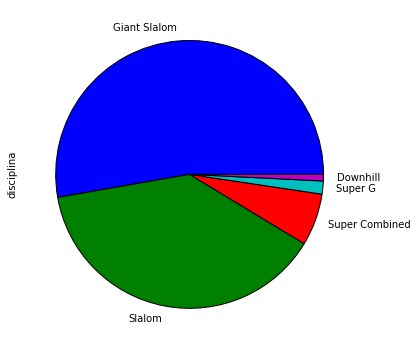

In [11]:
brem['disciplina'].value_counts().plot(kind='pie', figsize=(6,6))

Čeprav najpogosteje tekmuje v slalomu in veleslalomu, pa to nista nujno disciplini, v katerih dosega najboljše rezultate. Najprej si poglejmo, kakšni so njeni rezultati v slalomu in nato še veleslalomu:

In [12]:
slalom = brem['disciplina'] == 'Slalom'
brem[slalom][:15]

,datum,kraj,disciplina,mesto,zaostanek,mesto1,tocke
2,2016-06-03,Jasna,Slalom,26,46.21,26,5
3,2016-02-15,Crans Montana,Slalom,DNQ1,NaN,0,0
6,2016-01-15,Flachau,Slalom,26,22.85,26,5
7,2016-12-01,Flachau,Slalom,26,34.79,26,5
8,2016-05-01,Santa Caterina Valfurva,Slalom,26,36.17,26,5
9,2015-12-29,Lienz,Slalom,21,19.38,21,10
12,2015-12-13,Are,Slalom,17,24.38,17,14
14,2015-11-29,"Aspen, CO",Slalom,DNQ1,NaN,0,0
15,2015-11-28,"Aspen, CO",Slalom,20,45.09,20,11
19,2015-03-14,Are,Slalom,27,34.29,27,4


In [13]:
veleslalom = brem['disciplina'] == 'Giant Slalom'
brem[veleslalom][:15]

,datum,kraj,disciplina,mesto,zaostanek,mesto1,tocke
0,2016-03-20,St. Moritz,Giant Slalom,4,7.78,4,50
1,2016-07-03,Jasna,Giant Slalom,1,0.00,1,100
4,2016-01-30,Maribor,Giant Slalom,4,2.68,4,50
5,2016-01-17,Flachau,Giant Slalom,4,10.75,4,50
10,2015-12-28,Lienz,Giant Slalom,4,2.80,4,50
11,2015-12-20,Courchevel,Giant Slalom,1,0.00,1,100
13,2015-12-12,Are,Giant Slalom,2,0.55,2,80
16,2015-11-27,"Aspen, CO",Giant Slalom,2,0.80,2,80
17,2015-10-24,Soelden,Giant Slalom,8,19.56,8,32
18,2015-03-22,Meribel,Giant Slalom,2,2.53,2,80


Iz tabel je razvidno, da so njeni razultati v slalomu v vačini na repu trideseterice, med tem ko se v veleslalomu uvršča med 5 najboljših. To se še lepše vidi z grafov:

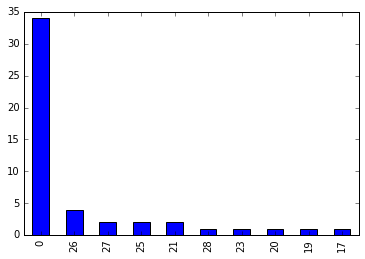

In [14]:
brem[slalom]['mesto1'].value_counts().plot(kind='bar')

In [15]:
urejen = brem[veleslalom].sort_values(['mesto1'], ascending=True)
#urejen['mesto1'].value_counts()
#urejen['mesto1'].value_counts().plot(kind='bar')
#ne more uredit, ker DNQ1, DNF1, DSQ2 in DNS1 niso legit uvrstitve.

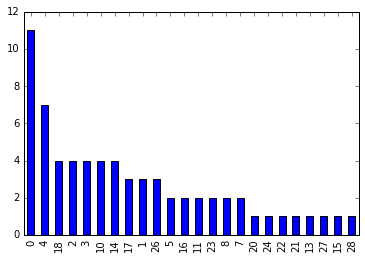

In [16]:
brem[veleslalom]['mesto1'].value_counts().plot(kind='bar')

## Analiza narodnosti

Zanima nas, koliko je smučarjev določene narodnosti. Najprej jih preštejmo, nato pa ponazorimo to z grafom:

In [17]:
smucarji['drzava'].value_counts()

AUT    61
SUI    45
ITA    42
FRA    39
USA    31
GER    26
SWE    20
CAN    18
NOR    18
SLO    15
CZE     8
RUS     5
SVK     4
FIN     4
CRO     3
JPN     2
HUN     2
ARG     2
GBR     2
POL     1
SRB     1
AND     1
LAT     1
SPA     1
AUS     1
MON     1
LIE     1
Name: drzava, dtype: int64

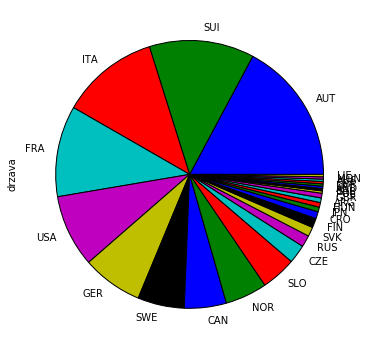

In [18]:
smucarji['drzava'].value_counts().plot(kind='pie', figsize = (6,6))

Popravi graf, da najmanjše lepo prikaže!!!

## Analiza smuči

Najprej si oglejmo, katere znamke smuči so najpogostejše v svetovnem pokalu:

In [19]:
smucarji['smuci'].value_counts()

Head          76
Rossignol     68
Fischer       48
Atomic        43
Voelkl        32
Salomon       25
Stoeckli      20
Nordica       14
Ni_podatka     9
Dynastar       9
Blizzard       6
Elan           4
Hart           1
Name: smuci, dtype: int64

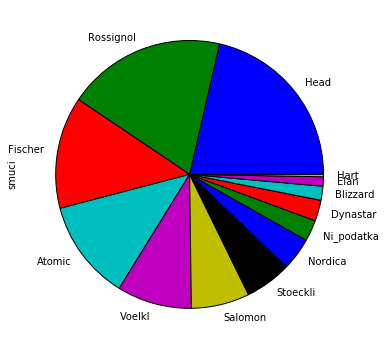

In [20]:
smucarji['smuci'].value_counts().plot(kind='pie', figsize=(6,6))

Poglejmo, predstavniki katerih držav uporabljajo smuči Head (in koliko jih je):

To do: naredi graf, ki bo prikazal to za vse smuči.

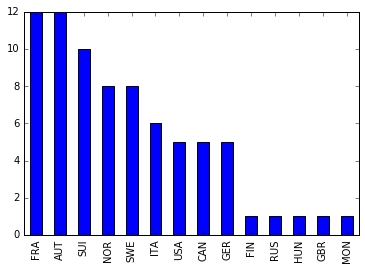

In [29]:
smucarji[smucarji['smuci'] == "Head"]['drzava'].value_counts().plot(kind='bar')

Podobno si lahko pogledamo, katerim proizvajalcem smuči najbolj zaupajo smučarji iz avstrije:

To do: naredi tak graf, ki bo prikazal to za vse države!

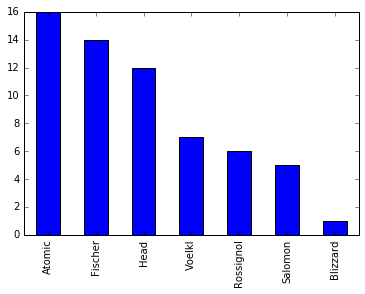

In [34]:
smucarji[smucarji['drzava'] == "AUT"]['smuci'].value_counts().plot(kind='bar')

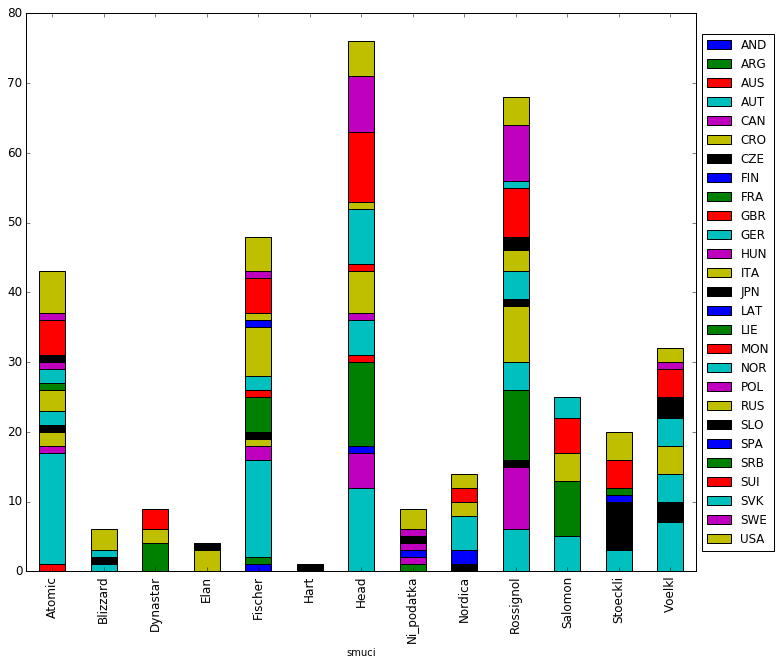

In [23]:
oboje = smucarji.groupby(['smuci', 'drzava']).size().unstack().plot(kind='bar', stacked=True, figsize=(12, 10), fontsize=12)
oboje.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1)

In [24]:
drzave=smucarji['drzava'].value_counts()[:10]
print(drzave)

AUT    61
SUI    45
ITA    42
FRA    39
USA    31
GER    26
SWE    20
CAN    18
NOR    18
SLO    15
Name: drzava, dtype: int64


In [25]:
print(drzave[0])

61


In [26]:
print(drzave['AUT'])

61


In [27]:
print(drzave.keys())

Index(['AUT', 'SUI', 'ITA', 'FRA', 'USA', 'GER', 'SWE', 'CAN', 'NOR', 'SLO'], dtype='object')


In [28]:
for i in drzave.keys():
    print(i)

AUT
SUI
ITA
FRA
USA
GER
SWE
CAN
NOR
SLO
